# Tutorial: Train and validate models

- 1. Load data and related packages
- 2. Train various models
    - 2.1 Trainer
    - 2.2 Automated hyperparameter tuning
    - 2.3 Custom metrics
    - 2.4 Visualize the results
    - 2.5 Save and load your Trainer
    - 2.6 Train other models
- 3. Cross validate models
    - 3.1 Trainer.cv()
    - 3.2 Automated hyperparameter tuning for .cv()
    - 3.3 CrossValidator

## 1. Load data and related packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

UCI Adult data are going to be used in this tutorial. The data contain both numerical and categorical features, and the target to predict is whether a person makes over 50K a year. It is a very simple binary classification task.

In [3]:
from catboost.datasets import adult
train, test = adult()

In [6]:
target_dict = {
    '<=50K': 0,
    '>50K': 1
}
train['income'] = train['income'].map(target_dict)
test['income'] = test['income'].map(target_dict)

In [7]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,0
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,0
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,0
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,0
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,0


In [8]:
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32561 non-null  float64
 1   workclass       30725 non-null  object 
 2   fnlwgt          32561 non-null  float64
 3   education       32561 non-null  object 
 4   education-num   32561 non-null  float64
 5   marital-status  32561 non-null  object 
 6   occupation      30718 non-null  object 
 7   relationship    32561 non-null  object 
 8   race            32561 non-null  object 
 9   sex             32561 non-null  object 
 10  capital-gain    32561 non-null  float64
 11  capital-loss    32561 non-null  float64
 12  hours-per-week  32561 non-null  float64
 13  native-country  31978 non-null  object 
 14  income          32561 non-null  int64  
dtypes: float64(6), int64(1), object(8)
memory usage: 3.7+ MB


Let's prepare the data. We need to encode categorical features.

In [10]:
from kuma_utils.preprocessing import (
    PrepPipeline, SelectCategorical, SelectNumerical, DistTransformer, Cast)
from sklearn.preprocessing import TargetEncoder, OrdinalEncoder

In [11]:
num_enc = PrepPipeline([
    SelectNumerical(exclude_cols=['income']),
    DistTransformer('standard'), 
    Cast(float)
])

cat_enc = PrepPipeline([
    SelectCategorical(exclude_cols=['income']),
    OrdinalEncoder(
        encoded_missing_value=np.nan, 
        handle_unknown='use_encoded_value', 
        unknown_value=np.nan),
    Cast(float)
])

In [12]:
train_cat, train_num = cat_enc.fit_transform(train), num_enc.fit_transform(train)
categorical_index = list(range(train_cat.shape[1]))
train_encoded = pd.concat([train_cat, train_num], axis=1) 
train_encoded.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,6.0,9.0,4.0,0.0,1.0,4.0,1.0,38.0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429
1,5.0,9.0,2.0,3.0,0.0,4.0,1.0,38.0,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153
2,3.0,11.0,0.0,5.0,1.0,4.0,1.0,38.0,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429
3,3.0,1.0,2.0,5.0,0.0,2.0,1.0,38.0,1.057047,0.425801,-1.197459,-0.145920,-0.21666,-0.035429
4,3.0,9.0,2.0,9.0,5.0,2.0,0.0,4.0,-0.775768,1.408176,1.134739,-0.145920,-0.21666,-0.035429


Looks good to me. Let's apply the same transform to test data.

In [13]:
test_encoded = pd.concat([cat_enc.transform(test), num_enc.transform(test)], axis=1)
test_encoded.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,3.0,1.0,4.0,6.0,3.0,2.0,1.0,38.0,-0.995706,0.350774,-1.197459,-0.145920,-0.21666,-0.035429
1,3.0,11.0,2.0,4.0,0.0,4.0,1.0,38.0,-0.042642,-0.947095,-0.420060,-0.145920,-0.21666,0.774468
2,1.0,7.0,2.0,10.0,0.0,4.0,1.0,38.0,-0.775768,1.394362,0.746039,-0.145920,-0.21666,-0.035429
3,3.0,15.0,2.0,6.0,0.0,2.0,1.0,38.0,0.397233,-0.279070,-0.031360,0.895083,-0.21666,-0.035429
4,NaN,15.0,4.0,NaN,3.0,4.0,0.0,38.0,-1.508894,-0.817458,-0.031360,-0.145920,-0.21666,-0.845327


In [14]:
labels, features = train['income'], train_encoded
labels_test, features_test = test['income'], test_encoded

## 2. Train models
Before going to training, let's define our evaluation metric. Since the task is binary classification, I will use ROC-AUC for evaluation.

In [15]:
from sklearn.metrics import roc_auc_score, make_scorer
from kuma_utils.training import Trainer, auc_metric, acc_metric

### 2.1 Trainer

In [16]:
x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2)

In [17]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': 0,
}
fit_params = {
    'num_boost_round': 500,
    'callbacks': [lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(10)]
}

trn = Trainer(LGBMClassifier)
trn.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    # logger='path_to_log', 
    params=params, fit_params=fit_params, 
)

Logger created at 24/02/10:10:10:08
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.918651	valid_1's auc: 0.920598
[20]	training's auc: 0.92622	valid_1's auc: 0.925666
[30]	training's auc: 0.930861	valid_1's auc: 0.92768
[40]	training's auc: 0.935512	valid_1's auc: 0.930641
[50]	training's auc: 0.938742	valid_1's auc: 0.931461
[60]	training's auc: 0.941544	valid_1's auc: 0.931796
Early stopping, best iteration is:
[59]	training's auc: 0.941264	valid_1's auc: 0.931892


In [18]:
trn

Trainer: trainer0
model: LGBMClassifier()
is_trained: True
best_iteration: 59
best_score: 0.9318923393996336

In [19]:
roc_auc_score(labels_test, trn.predict_proba(features_test)[:, 1])

0.9265914737916419

### 2.2 Automated hyperparameter tuning
Also, Trainer class has a built-in optuna function. Just set `tune_model=True` and it will search the best hyperparameters. Don't forget to set `n_trials` or `timeout` to prevent endless tuning (For LightGBM models, tuning will be terminated by itself).

**Model tuning for lightgbm is currently work in progress due to breaking changes :(**

In [20]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
}
fit_params = {
    'num_boost_round': 100,
    'callbacks': [lgb.early_stopping(stopping_rounds=10, verbose=False)]
}

In [21]:
trn = Trainer(LGBMClassifier)
trn.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    params=params, fit_params=fit_params,
    tune_model=True, timeout=30
)

Logger created at 24/02/10:10:10:10
10:10:11 [trial    0] New best: 0.931892 
{'feature_fraction': 1.0}
10:10:13 [trial    1] New best: 0.932550 
{'feature_fraction': 0.8999999999999999}
10:10:15 [trial    2] New best: 0.933000 
{'feature_fraction': 0.6}
10:10:18 [trial    4] New best: 0.933770 
{'feature_fraction': 0.5}
10:10:21 [trial    6] New best: 0.933773 
{'feature_fraction': 0.4}
10:10:23 [trial    7] New best: 0.930762 
{'num_leaves': 199}
10:10:25 [trial    8] New best: 0.933853 
{'num_leaves': 21}


In [22]:
roc_auc_score(labels_test, trn.predict_proba(features_test)[:, 1])

0.9283729789078977

In [23]:
trn

Trainer: trainer0
model: LGBMClassifier()
is_trained: True
best_iteration: 89
best_score: 0.9338527236864075

### 2.3 Custom metrics

In [24]:
from kuma_utils.metrics import SensitivityAtFixedSpecificity

params = {
    'objective': 'binary',
    'metric': 'SensitivityAtFixedSpecificity',
    'verbose': -1
}
fit_params = {
    'num_boost_round': 500,
    'callbacks': [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(25)],
    'feval': SensitivityAtFixedSpecificity(sp=0.9).lgbm
}

trn = Trainer(LGBMClassifier)
trn.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    # logger='path_to_log', 
    params=params, fit_params=fit_params, 
)

specify optimization direction for metric SensitivityAtFixedSpecificity.
Logger created at 24/02/10:10:10:40
Training until validation scores don't improve for 50 rounds
[25]	training's SensitivityAtFixedSpecificity: 0.764481	valid_1's SensitivityAtFixedSpecificity: 0.750953
[50]	training's SensitivityAtFixedSpecificity: 0.790649	valid_1's SensitivityAtFixedSpecificity: 0.757306
[75]	training's SensitivityAtFixedSpecificity: 0.810914	valid_1's SensitivityAtFixedSpecificity: 0.757306
Early stopping, best iteration is:
[40]	training's SensitivityAtFixedSpecificity: 0.782512	valid_1's SensitivityAtFixedSpecificity: 0.760483


### 2.4 Visualize the results

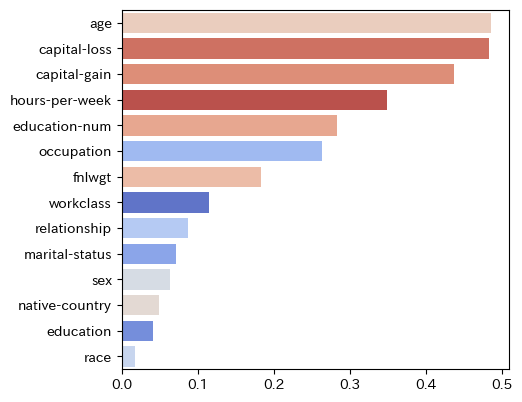

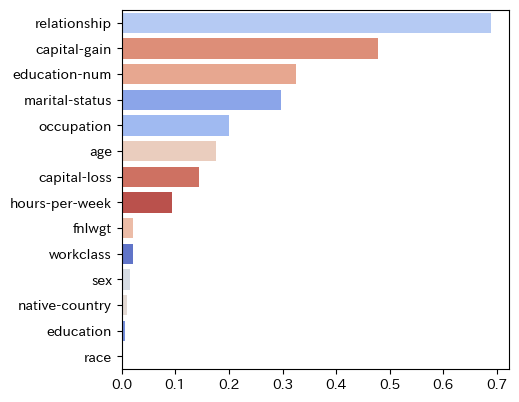

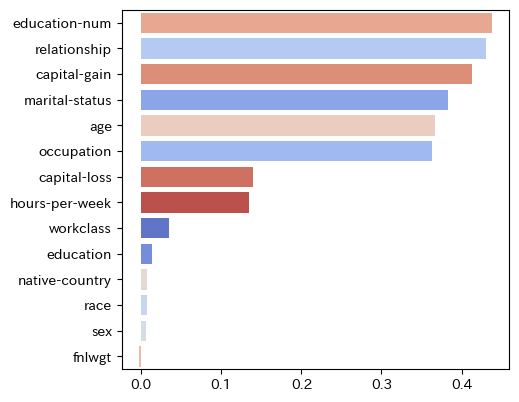

In [25]:
trn.plot_feature_importance()
trn.plot_feature_importance(importance_type='gain')
trn.plot_feature_importance(
    importance_type='permutation', fit_params={
        'X': x_valid, 'y': y_valid, 'scoring': make_scorer(roc_auc_score), 'n_jobs': -1})

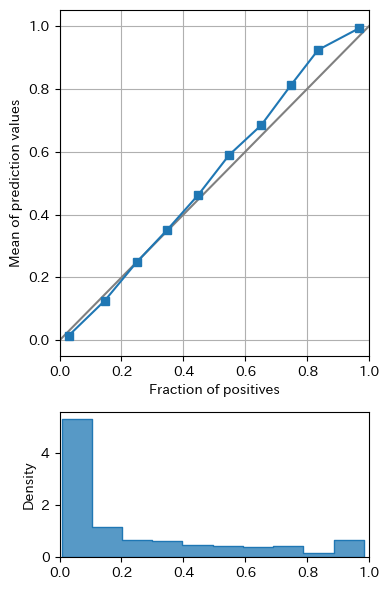

In [26]:
trn.plot_calibration_curve(data=(x_train, y_train))

### 2.5 Save and load Trainer

In [28]:
trn.save('lgbm0.trainer')
trn = Trainer(path='lgbm0.trainer')
trn

Trainer: trainer0
model: LGBMClassifier()
is_trained: True
best_iteration: 40
best_score: 0.6925031766200762

### 2.6 Train other models

In [29]:
params = {
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'iterations': 100,
    'use_best_model': True,
} 
fit_params = {
    'early_stopping_rounds': 10,
    'verbose_eval': 25
}

# Preprecessing for CatBoost
x_train_cat = x_train.copy()
x_valid_cat = x_valid.copy()
features_test_cat = features_test.copy()
x_train_cat.iloc[:, categorical_index] = x_train_cat.iloc[:, categorical_index].astype('str')
x_valid_cat.iloc[:, categorical_index] = x_valid_cat.iloc[:, categorical_index].astype('str')
features_test_cat.iloc[:, categorical_index] = features_test_cat.iloc[:, categorical_index].astype('str')


trn2 = Trainer(CatBoostClassifier)
trn2.train(
    train_data=(x_train_cat, y_train), 
    valid_data=(x_valid_cat, y_valid),
    cat_features=categorical_index,
    params=params,
    tune_model=True, n_trials=20,
    fit_params=fit_params)

Logger created at 24/02/10:10:14:39
10:14:39 [trial    0] New best: 0.919328 
{ 'boosting_type': 'Plain',
  'bootstrap_type': 'MVS',
  'colsample_bylevel': 0.06295100098476811,
  'depth': 5,
  'objective': 'CrossEntropy'}
10:14:40 [trial    5] New best: 0.920955 
{ 'boosting_type': 'Ordered',
  'bootstrap_type': 'Bernoulli',
  'colsample_bylevel': 0.08279192055197848,
  'depth': 3,
  'objective': 'Logloss',
  'subsample': 0.30805540676318116}
10:14:41 [trial    8] New best: 0.921260 
{ 'boosting_type': 'Ordered',
  'bootstrap_type': 'MVS',
  'colsample_bylevel': 0.09134295825058165,
  'depth': 3,
  'objective': 'Logloss'}
10:14:41 [trial    9] New best: 0.922048 
{ 'boosting_type': 'Plain',
  'bootstrap_type': 'MVS',
  'colsample_bylevel': 0.08006719693227421,
  'depth': 5,
  'objective': 'CrossEntropy'}
10:14:41 [trial   10] New best: 0.923749 
{ 'boosting_type': 'Plain',
  'bootstrap_type': 'MVS',
  'colsample_bylevel': 0.0999838911365308,
  'depth': 8,
  'objective': 'CrossEntropy'}

In [30]:
roc_auc_score(labels_test, trn2.smart_predict(features_test_cat))

0.9173902838703013

In [31]:
params = {
    'booster': 'gbtree', 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'verbosity': 0,
    'num_round': 100,
}
fit_params = {
    'early_stopping_rounds': 10,
    'verbose_eval': False
}

trn3 = Trainer(XGBClassifier)
trn3.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    params=params,
    eval_metric=auc_metric, maximize=True,
    tune_model=True, n_trials=20,
    fit_params=fit_params)

Logger created at 24/02/10:10:14:43
10:14:43 [trial    0] New best: 0.739863 
{ 'alpha': 0.03256770017179281,
  'booster': 'gbtree',
  'eta': 0.0017291402655398558,
  'gamma': 0.0031042085070046004,
  'grow_policy': 'depthwise',
  'lambda': 1.8979980393919807e-05,
  'max_depth': 1}
10:14:43 [trial    1] New best: 0.739863 
{ 'alpha': 0.03256770017179281,
  'booster': 'gbtree',
  'eta': 0.0017291402655398558,
  'gamma': 0.0031042085070046004,
  'grow_policy': 'depthwise',
  'lambda': 1.8979980393919807e-05,
  'max_depth': 1}
10:14:43 [trial    2] New best: 0.910852 
{ 'alpha': 3.1379020778100013e-07,
  'booster': 'dart',
  'eta': 2.4190904753398896e-05,
  'gamma': 0.0005046778747190058,
  'grow_policy': 'depthwise',
  'lambda': 0.012541928795858746,
  'max_depth': 8,
  'normalize_type': 'forest',
  'rate_drop': 0.005022325561491912,
  'sample_type': 'uniform',
  'skip_drop': 0.030765961615517583}
10:14:45 [trial   15] New best: 0.911476 
{ 'alpha': 5.7032406685660034e-05,
  'booster': '

In [32]:
roc_auc_score(labels_test, trn3.predict_proba(features_test)[:, 1])

0.9185915591026536

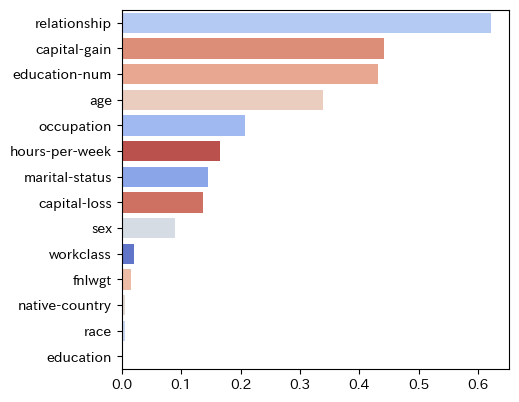

In [33]:
trn3.plot_feature_importance(
    'permutation', fit_params={
        'X': x_valid, 'y': y_valid, 'scoring': make_scorer(roc_auc_score), 'n_jobs': -1})

## 3. Cross validate models

### 3.1 Trainer.cv()

In [34]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1
}
fit_params = {
    'num_boost_round': 100,
    'callbacks': [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(25)]
}

trn = Trainer(LGBMClassifier)
trn.cv(
    data=(features, labels), 
    cat_features=categorical_index,
    folds=StratifiedKFold(n_splits=5), 
    params=params, fit_params=fit_params, 
)

Logger created at 24/02/10:10:14:46
Training until validation scores don't improve for 50 rounds
[25]	cv_agg's valid auc: 0.922025 + 0.00264879
[50]	cv_agg's valid auc: 0.927481 + 0.00227593
[75]	cv_agg's valid auc: 0.928261 + 0.00211113
[100]	cv_agg's valid auc: 0.928544 + 0.00212961
Did not meet early stopping. Best iteration is:
[96]	cv_agg's valid auc: 0.928548 + 0.00216293
10:14:53 [96]	best score is 0.928548


In [35]:
trn

Trainer: trainer0
model: [LGBMClassifier(), LGBMClassifier(), LGBMClassifier(), LGBMClassifier(), LGBMClassifier()]
is_trained: True
best_iteration: 96
best_score: 0.9285480621915914

In [36]:
roc_auc_score(labels_test, np.stack(trn.smart_predict(features_test)).mean(0))

0.9281075947501107

Note that `Trainer.cv()` is equivalent to `lightgbm.cv()` or `xgboost.cv()`. 

Otherwise, there is a `CrossValidator` class in which you can control details of cross validation operation.

### 3.2 Automated hyperparameter tuning for Trainer.cv()

In [37]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1
}
fit_params = {
    'num_boost_round': 100,
    'callbacks': [lgb.early_stopping(stopping_rounds=50, verbose=False)]
}

trn = Trainer(LGBMClassifier)
trn.cv(
    data=(features, labels), 
    cat_features=categorical_index,
    folds=StratifiedKFold(n_splits=5), 
    params=params, fit_params=fit_params, 
    tune_model=True, timeout=30
)

Logger created at 24/02/10:10:14:53
10:15:00 [trial    0] New best: 0.929459 
{'feature_fraction': 0.6}
10:15:25 [100]	best score is 0.929459


In [38]:
trn

Trainer: trainer0
model: [LGBMClassifier(), LGBMClassifier(), LGBMClassifier(), LGBMClassifier(), LGBMClassifier()]
is_trained: True
best_iteration: 100
best_score: 0.9294590854663317

In [39]:
roc_auc_score(labels_test, np.stack(trn.smart_predict(features_test)).mean(0))

0.9292162301691103

In [40]:
params = {
    'booster': 'gbtree', 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'verbosity': 0,
    'num_round': 100,
}
fit_params = {
    'early_stopping_rounds': 10,
    'verbose_eval': False
}

trn = Trainer(XGBClassifier)
trn.cv(
    data=(features, labels), 
    cat_features=categorical_index,
    folds=StratifiedKFold(n_splits=5),
    tune_model=True, n_trials=20,
    params=params, fit_params=fit_params)

Logger created at 24/02/10:10:15:25
10:15:26 [trial    0] New best: 0.847186 
{ 'alpha': 9.789291930828451e-06,
  'booster': 'dart',
  'eta': 0.00021971199485748964,
  'gamma': 0.07032787455249516,
  'grow_policy': 'lossguide',
  'lambda': 0.000203557909603148,
  'max_depth': 3,
  'normalize_type': 'forest',
  'rate_drop': 2.5902742557710275e-07,
  'sample_type': 'weighted',
  'skip_drop': 6.052272691504603e-05}
10:15:26 [trial    1] New best: 0.891405 
{ 'alpha': 1.1996118106638554e-07,
  'booster': 'dart',
  'eta': 1.804155410226147e-06,
  'gamma': 0.0010411094828788386,
  'grow_policy': 'lossguide',
  'lambda': 0.21734196181312024,
  'max_depth': 6,
  'normalize_type': 'forest',
  'rate_drop': 1.0494374494077084e-08,
  'sample_type': 'uniform',
  'skip_drop': 6.207181826051132e-06}
10:15:29 [trial    7] New best: 0.904031 
{ 'alpha': 2.657544972575394e-05,
  'booster': 'gbtree',
  'eta': 0.016109265407572376,
  'gamma': 5.157277302156944e-06,
  'grow_policy': 'depthwise',
  'lambda'

### 3.3 CrossValidator

In [41]:
from kuma_utils.training import CrossValidator

In [42]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1
}
fit_params = {
    'num_boost_round': 100,
    'callbacks': [lgb.early_stopping(stopping_rounds=50, verbose=False)]
}


validator = CrossValidator(LGBMClassifier)
validator.train(
    data=(features, labels), params=params, fit_params=fit_params,
    folds=StratifiedKFold(n_splits=5)
)

Logger created at 24/02/10:10:15:40
10:15:40 [cv0] Starting fold 0
10:15:42 [cv0] Fold 0: eval=0.925781 (iter=99)
10:15:42 [cv0] Starting fold 1
10:15:44 [cv0] Fold 1: eval=0.923952 (iter=97)
10:15:44 [cv0] Starting fold 2
10:15:45 [cv0] Fold 2: eval=0.929432 (iter=100)
10:15:45 [cv0] Starting fold 3
10:15:47 [cv0] Fold 3: eval=0.928901 (iter=96)
10:15:47 [cv0] Starting fold 4
10:15:49 [cv0] Fold 4: eval=0.929409 (iter=86)
10:15:49 [cv0] Overall metric: 0.927495 + 0.002231


In [43]:
validator

CrossValidator: cv0
models: [Trainer: cv0_fold0
model: LGBMClassifier()
is_trained: True
best_iteration: 99
best_score: 0.9257809196590082
, Trainer: cv0_fold1
model: LGBMClassifier()
is_trained: True
best_iteration: 97
best_score: 0.9239520899379169
, Trainer: cv0_fold2
model: LGBMClassifier()
is_trained: True
best_iteration: 100
best_score: 0.9294320883693283
, Trainer: cv0_fold3
model: LGBMClassifier()
is_trained: True
best_iteration: 96
best_score: 0.9289010772695
, Trainer: cv0_fold4
model: LGBMClassifier()
is_trained: True
best_iteration: 86
best_score: 0.9294094496111551
]
is_trained: True
best_score: [0.9274951249693817, 0.0022309085591902342]

In [44]:
roc_auc_score(labels_test, np.stack(validator.smart_predict(features_test)).mean(0))

0.9275192101371228

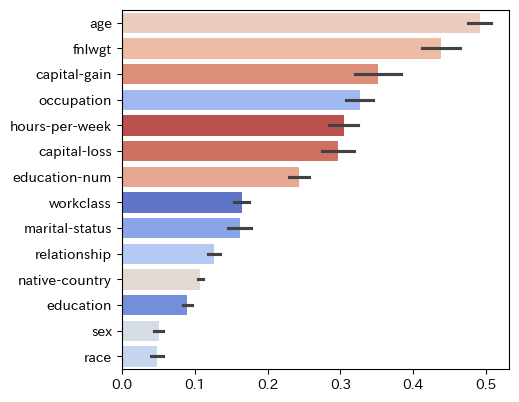

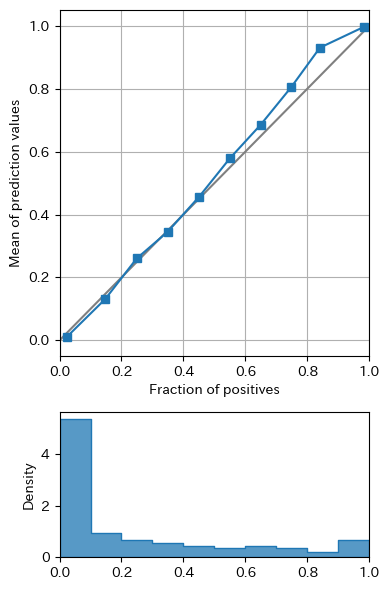

In [45]:
validator.plot_feature_importance(),
validator.plot_calibration_curve(data=(features, labels))